In [1]:
import pandas as pd
import random
# import numpy as np
# import seaborn as sns

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

In [3]:
from eventframing.eventframe import EventFrame

from data_preprocessing import AddStartEndEventsPreprocessor, SplitSessionsPreprocessor

In [4]:
from ux_researching import DescStatsAnalyzer

In [5]:
from tooling import Cohorts, Funnel

# Data loading

In [6]:
data = pd.read_csv("D:/SUSU/diplom/simple_shop.csv")

In [7]:
users = data['user_id'].unique()
cities = [random.choice(['NY', 'SF', 'LA']) for _ in range(len(users))]
genders = [random.choice(['M', 'F']) for _ in range(len(users))]
users = pd.DataFrame({'user_id': users, 'city': cities, 'gender': genders})

data = data.merge(users, on='user_id', how='inner')

In [8]:
data.shape

(32283, 5)

In [9]:
data.head()

,user_id,event,timestamp,city,gender
0,219483890,catalog,2019-11-01 17:59:13.273932,LA,M
1,219483890,product1,2019-11-01 17:59:28.459271,LA,M
2,219483890,cart,2019-11-01 17:59:29.502214,LA,M
3,219483890,catalog,2019-11-01 17:59:32.557029,LA,M
4,219483890,main,2019-12-06 16:22:57.484842,LA,M


In [10]:
data.event.value_counts()

catalog             14518
main                 5635
cart                 2842
product2             2172
delivery_choice      1686
product1             1515
payment_choice       1107
delivery_courier      834
payment_done          706
payment_card          565
delivery_pickup       506
payment_cash          197
Name: event, dtype: int64

# EDA

In [11]:
cols_schema = {
    'user_id': 'user_id',
    'event_name': 'event',
    'event_timestamp': 'timestamp'
}

ef = EventFrame(data, cols_schema=cols_schema, prepare=True)

In [12]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,gender,event_id,event_type,event_type_index
19311,122915,main,2020-04-07 03:27:32.806542,NY,M,19311,raw,2
19312,122915,catalog,2020-04-07 03:27:49.914239,NY,M,19312,raw,2
19313,122915,main,2020-04-07 03:27:57.320839,NY,M,19313,raw,2
19314,122915,main,2020-04-07 03:28:00.580589,NY,M,19314,raw,2
19315,122915,catalog,2020-04-07 03:28:01.815559,NY,M,19315,raw,2


Применение препроцессоров для извлечения дополнительной информации о действиях пользователей

In [13]:
start_end_events_preprocessor = AddStartEndEventsPreprocessor()
split_sessions_preprocessor = SplitSessionsPreprocessor(timeout=(15, 'm'))

In [14]:
ef = start_end_events_preprocessor.apply(ef)

In [15]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,gender,event_id,event_type,event_type_index
32283,122915,path_start,2020-04-07 03:27:32.806542,NY,M,122915_path_start,path_start,0
0,122915,main,2020-04-07 03:27:32.806542,NY,M,19311,raw,2
1,122915,catalog,2020-04-07 03:27:49.914239,NY,M,19312,raw,2
2,122915,main,2020-04-07 03:27:57.320839,NY,M,19313,raw,2
3,122915,main,2020-04-07 03:28:00.580589,NY,M,19314,raw,2


In [16]:
ef = split_sessions_preprocessor.apply(ef)

In [17]:
ef.to_dataframe().head()

,user_id,event,timestamp,city,gender,event_id,event_type,event_type_index,session_id
32283,122915,path_start,2020-04-07 03:27:32.806542,NY,M,122915_path_start,path_start,0,122915_1
32283,122915,session_start,2020-04-07 03:27:32.806542,NY,M,122915_1session_start,session_start,1,122915_1
0,122915,main,2020-04-07 03:27:32.806542,NY,M,19311,raw,2,122915_1
1,122915,catalog,2020-04-07 03:27:49.914239,NY,M,19312,raw,2,122915_1
2,122915,main,2020-04-07 03:27:57.320839,NY,M,19313,raw,2,122915_1


Изучение базовых статистик по поведению пользователей

In [18]:
desc_stats_analyzer = DescStatsAnalyzer()

In [19]:
desc_stats_analyzer.describe(
    ef,
    add_path_stats=True,
    add_session_stats=True
)

value
category             metric                                     
overall              unique_users                           3751
                     unique_events                            12
                     unique_sessions                        6456
                     frame_start      2019-11-01 17:59:13.273932
                     frame_end        2020-04-29 12:48:06.595390
                     frame_duration     179 days 18:48:53.321458
path_duration        mean              9 days 11:15:17.575685977
                     median               0 days 00:01:20.849291
                     std              23 days 02:52:24.851865733
                     min                         0 days 00:00:00
                     max                149 days 04:51:04.723411
path_steps_length    mean                               8.606505
                     median                                  6.0
                     std                                9.098354
                     min                                       1
                     max                                     100
session_duration     mean              0 days 00:00:51.218505473
                     median            0 days 00:00:30.258548500
                     std               0 days 00:01:04.415111612
                     min                         0 days 00:00:00
                     max                  0 days 00:12:08.677025
session_steps_length mean                               5.000465
                     median                                  4.0
                     std                                4.179011
                     min                                       1
                     max                                      53

In [20]:
desc_stats_analyzer.describe_events(ef, events=['catalog', 'cart', 'payment_done'])

TypeError: Cannot cast TimedeltaArray to dtype float64

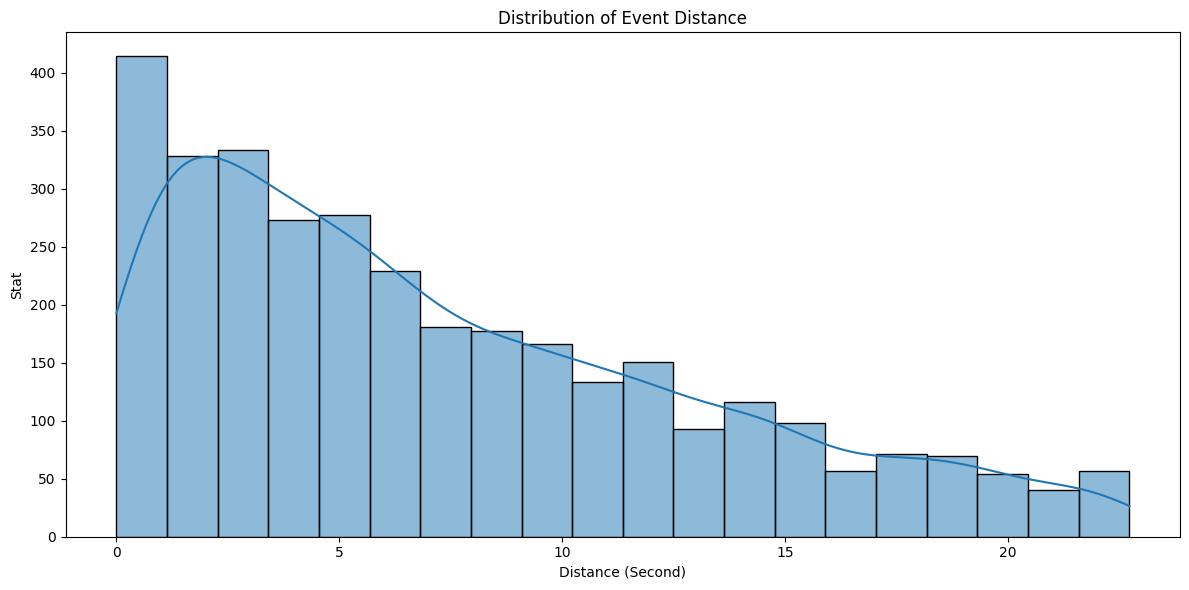

In [21]:
desc_stats_analyzer.plot_event_distance_hist(ef, event_from='catalog', event_to=['product1', 'product2'], plot_period='s', upper_cutoff_quantile=0.9)

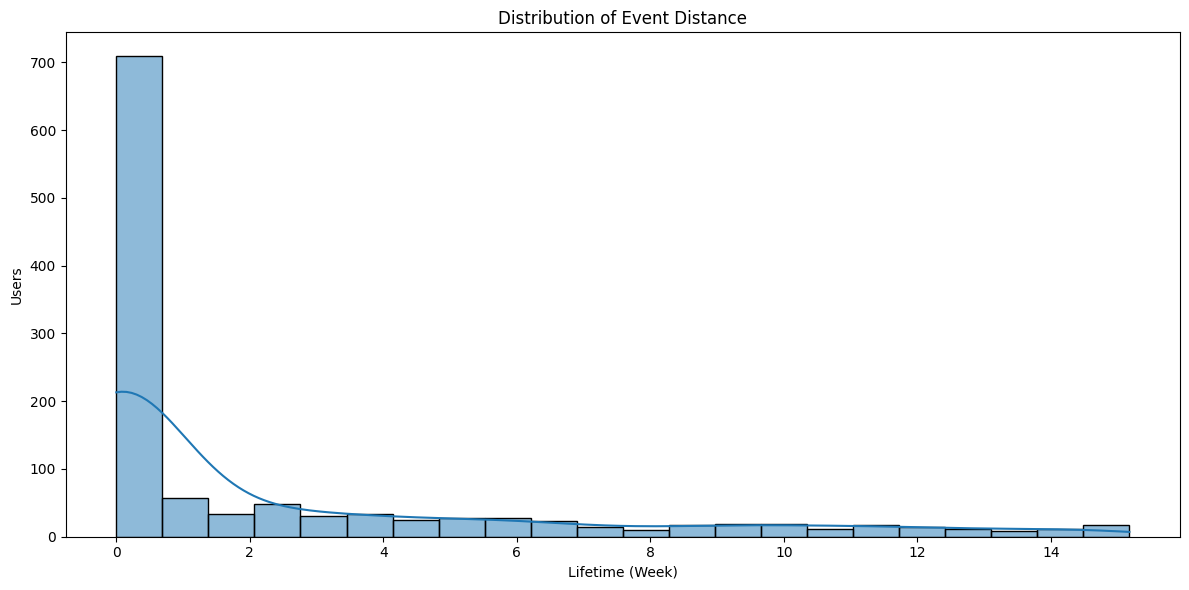

In [22]:
desc_stats_analyzer.plot_lifetime_hist(ef, max_return_time=(1, 'M'), plot_period='W')

## Воронка в покупку

In [23]:
funnel = Funnel()

In [24]:
funnel.plot(ef, stages=['catalog', 'cart', 'payment_done'])

In [25]:
data['city'].unique()

array(['SF', 'NY', 'LA'], dtype=object)

In [26]:
ny_users = ef.filter(conditions=['city == "NY"']).to_dataframe().index
la_users = ef.filter(conditions=['city == "LA"']).to_dataframe().index
funnel.plot(
    ef, 
    stages=[['product1', 'product2'], 'cart', 'payment_done'],
    stages_names=['product', 'cart', 'payment'],
    funnel_type='closed',
    segments=[ny_users, la_users],
    segments_names=['NY', 'LA']
)

In [27]:
cohorts = Cohorts()

In [28]:
_ = cohorts.fit(ef, normalize=True, cohort_period='W', represent_by='period')

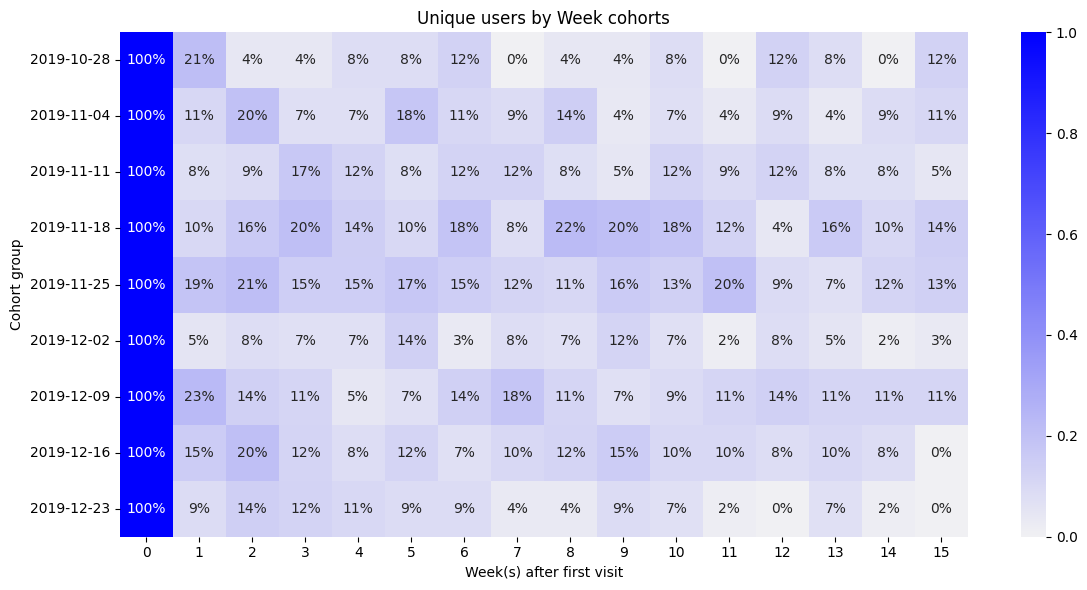

In [29]:
cohorts.plot(min_cohort='2019-10-28', max_cohort='2019-12-23', max_period=15)

In [30]:
data.event.unique()

array(['catalog', 'product1', 'cart', 'delivery_choice', 'main',
       'product2', 'delivery_courier', 'payment_choice', 'payment_cash',
       'payment_done', 'delivery_pickup', 'payment_card'], dtype=object)

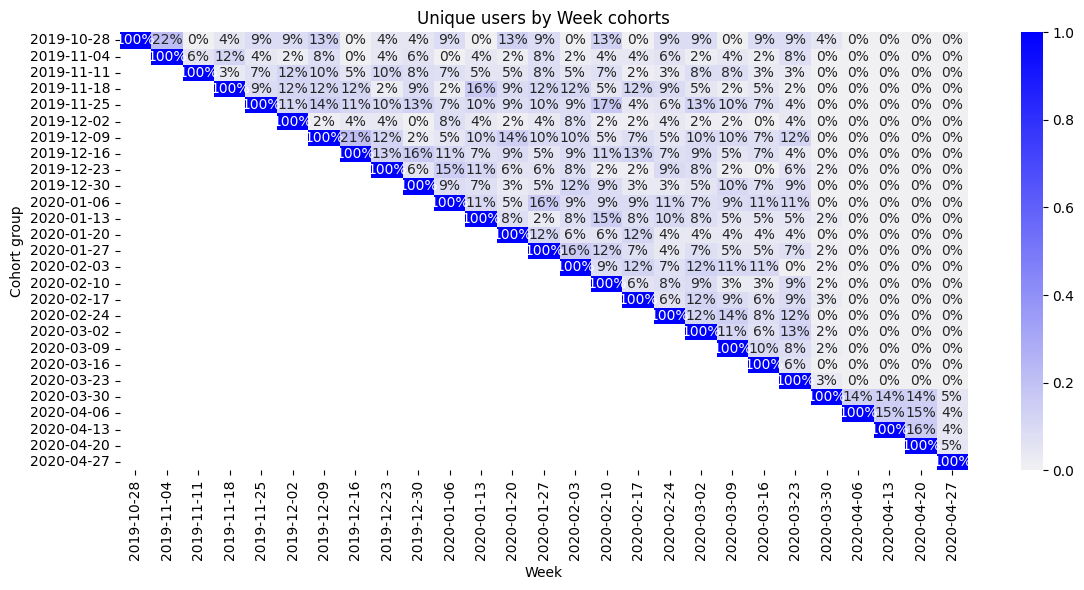

In [31]:
_ = cohorts.fit(
    ef.filter(conditions=['event.isin(["catalog"])']), 
    normalize=True, 
    cohort_period='W', 
    represent_by='time_unit'
)
cohorts.plot()

## Кластеризация


In [32]:
from clustering import ClusteringDataPreprocessor, KMeansEstimator, DBScanEstimator

In [33]:
clustering_preprocessor = ClusteringDataPreprocessor()
cluster_matrix = clustering_preprocessor.create_cluster_matrix(
    ef, add_session_stats=True,
    add_path_stats=True,
    preprocess=True
)

In [34]:
cluster_matrix.head()

,cart,catalog,delivery_choice,delivery_courier,delivery_pickup,main,payment_card,payment_cash,payment_choice,payment_done,...,max_gap,mean_gap,median_gap,min_amount_of_steps,max_amount_of_steps,mean_amount_of_steps,median_amount_of_steps,lifetime,amount_of_active_days,user_id
0,0.239239,3.475441,-0.638274,-0.465821,-0.363095,2.646944,-0.385087,-0.225952,-0.530626,-0.438485,...,0.009287,0.070215,0.136705,0.744412,4.068827,2.976598,2.977932,-0.147580,0.212429,122915
1,-0.747984,1.015747,-0.638274,-0.465821,-0.363095,-0.241821,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,1.554085,0.821557,1.336512,1.352088,-0.409530,-0.488999,463458
2,0.239239,0.277839,0.781753,1.629257,-0.363095,0.239639,-0.385087,-0.225952,1.267368,-0.438485,...,1.402066,1.681001,1.852830,-0.335151,1.038042,0.516468,0.539167,0.608883,0.212429,1475907
3,-0.747984,-0.952008,-0.638274,-0.465821,-0.363095,-0.241821,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,-0.874933,-1.126805,-1.123619,-1.086677,-0.409616,-0.488999,1576626
4,-0.747984,-0.214100,-0.638274,-0.465821,-0.363095,0.239639,-0.385087,-0.225952,-0.530626,-0.438485,...,-0.473166,-0.487755,-0.457755,0.204631,-0.260867,-0.030228,-0.002781,-0.409592,-0.488999,2112338


In [35]:
cluster_matrix.columns

Index(['cart', 'catalog', 'delivery_choice', 'delivery_courier',
       'delivery_pickup', 'main', 'payment_card', 'payment_cash',
       'payment_choice', 'payment_done', 'product1', 'product2',
       'amount_of_sessions', 'min_duration', 'max_duration', 'mean_duration',
       'median_duration', 'min_gap', 'max_gap', 'mean_gap', 'median_gap',
       'min_amount_of_steps', 'max_amount_of_steps', 'mean_amount_of_steps',
       'median_amount_of_steps', 'lifetime', 'amount_of_active_days',
       'user_id'],
      dtype='object')

In [36]:
users_clusters = cluster_matrix.user_id.to_frame()
cluster_matrix = cluster_matrix.drop(columns=['user_id'])

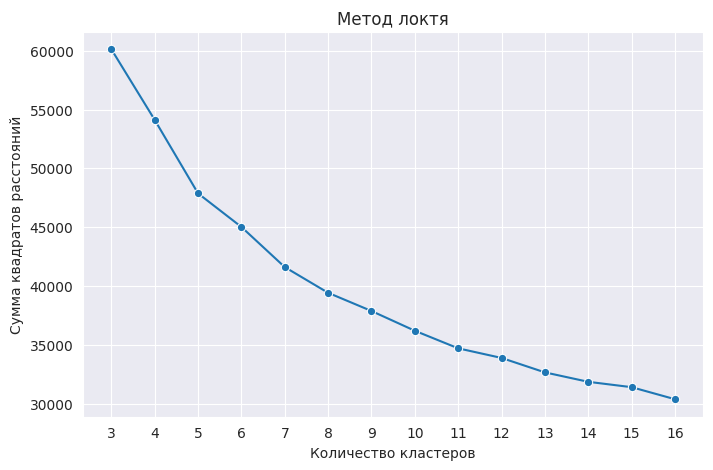

In [37]:
n_clusters_range = (3, 16)
KMeansEstimator.choose_optimal_n_clusters(n_clusters_range, cluster_matrix, method='elbow')

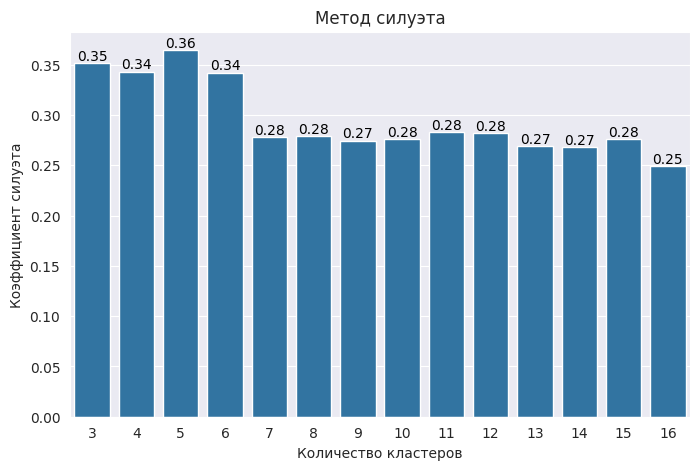

In [38]:
KMeansEstimator.choose_optimal_n_clusters(n_clusters_range, cluster_matrix, method='silhouette')

In [39]:
kmeans = KMeansEstimator(8)

In [40]:
kmeans.fit(cluster_matrix)

KMeans(max_iter=1000)

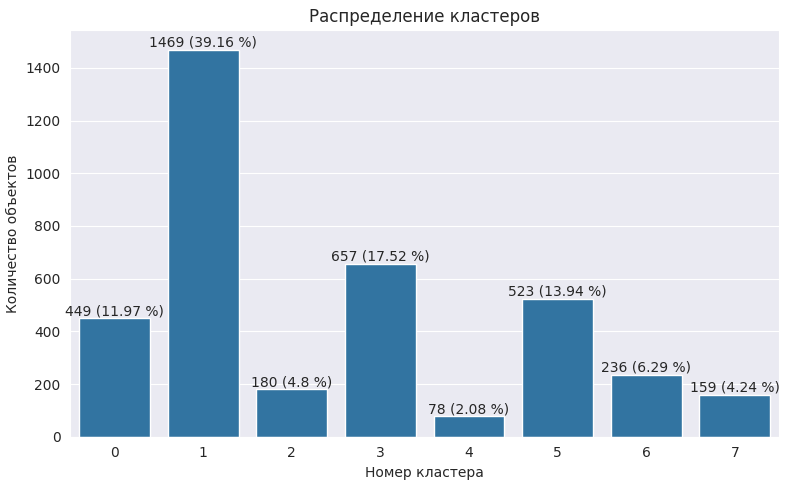

In [41]:
kmeans.plot_clusters_counts()

In [42]:
kmeans.describe_by_centroids()

,cluster,cart,catalog,delivery_choice,delivery_courier,delivery_pickup,main,payment_card,payment_cash,payment_choice,...,min_gap,max_gap,mean_gap,median_gap,min_amount_of_steps,max_amount_of_steps,mean_amount_of_steps,median_amount_of_steps,lifetime,amount_of_active_days
0,0,-0.079575,0.183614,-0.274570,-0.307174,-0.177258,0.471255,-0.379393,-0.158879,-0.398480,...,0.0,0.626893,0.722404,0.723603,-0.618867,-0.090668,-0.375283,-0.396870,0.309923,0.567049
1,1,-0.559814,-0.583640,-0.559974,-0.443002,-0.324617,-0.469606,-0.385087,-0.225952,-0.523283,...,0.0,-0.443790,-0.454038,-0.422379,-0.527326,-0.815415,-0.751030,-0.717385,-0.393289,-0.428836
2,2,0.568314,0.991150,0.474080,0.383849,0.160279,0.009608,0.239852,-0.010839,0.428304,...,0.0,-0.415370,-0.422529,-0.391707,2.755099,1.923223,2.637951,2.637709,-0.376934,-0.438340
3,3,-0.137919,0.089898,-0.281646,-0.357400,-0.137768,-0.257211,-0.385087,-0.225952,-0.478630,...,0.0,-0.442177,-0.452031,-0.419941,0.555858,0.138164,0.399695,0.423683,-0.392727,-0.420671
4,4,3.403417,3.872776,3.021025,2.273897,1.776413,4.004911,1.712608,2.145805,2.696542,...,0.0,2.356115,1.861834,1.369482,-0.684625,1.884552,0.315892,0.044118,3.772605,4.178197
5,5,0.450652,-0.327444,0.939232,0.988315,0.686799,-0.307182,1.281814,0.407459,1.373941,...,0.0,-0.262562,-0.249008,-0.211977,0.758861,0.554573,0.760634,0.773354,-0.287950,-0.239543
6,6,1.372873,1.470165,1.359391,1.203139,0.503704,1.051595,0.665705,0.649084,1.168326,...,0.0,0.761061,0.822655,0.798768,-0.139595,1.550817,0.829839,0.728619,0.504791,0.869275
7,7,0.133687,0.375298,-0.013105,-0.149583,0.009333,1.544732,-0.095664,0.125805,-0.123533,...,0.0,3.205417,3.185679,2.877488,-0.749323,-0.008982,-0.528049,-0.635054,3.155091,2.043201


In [43]:
# kmeans.plot_clusters_with_tsne(cluster_matrix)

In [44]:
users_clusters['cluster'] = kmeans.labels_

In [45]:
ef_data = ef.to_dataframe()
ef_data = ef_data.merge(users_clusters, on='user_id', how='inner')
ef = EventFrame(ef_data, cols_schema=ef.cols_schema, prepare=False)

## Расчет продуктовых метрик

In [21]:
from metrics.metric import MetricKPI, MetricDinamic

In [22]:
def convertion_to_deliv_pickup_formula(data):
    choised_users = data[data['event'] == 'delivery_choice']['user_id'].unique()
    n_choised_users = len(choised_users)
    delivered_users = data[data['event'] == 'delivery_pickup']['user_id'].unique()
    delivered_users = [user_id for user_id in delivered_users if user_id in choised_users]
    n_delivered_users = len(delivered_users)
    return n_delivered_users / n_choised_users

In [23]:
convertion_to_deliv_pickup_kpi = MetricKPI(convertion_to_deliv_pickup_formula, name='Convertion from delivery choise to pickup') 

In [24]:
conv = convertion_to_deliv_pickup_kpi.compute_single_value(ef)
print(f'{convertion_to_deliv_pickup_kpi.name} = {round(conv * 100, 2)} %')

Convertion from delivery choise to pickup = 34.59 %


In [25]:
convertion_to_deliv_pickup_kpi.compute_splitted_values(ef, hue_cols='city')

,city,Convertion from delivery choise to pickup
0,NY,0.308855
1,LA,0.372768
2,SF,0.357303


In [26]:
# convertion_to_deliv_pickup_kpi.compute_splitted_values(ef, hue_cols='cluster')

In [27]:
def compute_convertion(data, cols_schema, source_event: str, target_event: str, strict: bool = False):
    user_id_col = cols_schema.user_id
    event_col = cols_schema.event_name

    source_users = data[data[event_col] == source_event][user_id_col].unique()
    n_source_users = len(source_users)
    target_users = data[data[event_col] == target_event][user_id_col].unique()
    if strict:
        target_users = [user_id for user_id in target_users if user_id in source_users]
    n_target_users = len(target_users)
    return n_target_users / n_source_users if n_source_users > 0 else 0
    

In [28]:
convertion_metric_dinamic = MetricDinamic(compute_convertion, name='convertion')

In [29]:
formula_kwargs = {'source_event': 'catalog', 'target_event': 'payment_done', 'strict': False, 'cols_schema': ef.cols_schema}

convertion_metric_dinamic.compute(
    ef, 
    period='W',
    formula_kwargs=formula_kwargs
)

,Week,convertion
0,2019-10-28,0.086957
1,2019-11-04,0.089286
2,2019-11-11,0.048387
3,2019-11-18,0.153846
4,2019-11-25,0.146341
5,2019-12-02,0.213333
6,2019-12-09,0.112676
7,2019-12-16,0.146341
8,2019-12-23,0.142857
9,2019-12-30,0.118280


In [30]:
convertion_metric_dinamic.compute(
    ef, 
    period='M',
    hue_cols=['city', 'gender'],
    formula_kwargs=formula_kwargs
)

,Month,city,gender,convertion
3,2019-11-01,LA,F,0.104167
2,2019-11-01,LA,M,0.090909
1,2019-11-01,NY,F,0.097561
0,2019-11-01,NY,M,0.209302
5,2019-11-01,SF,F,0.138889
4,2019-11-01,SF,M,0.085714
9,2019-12-01,LA,F,0.317073
8,2019-12-01,LA,M,0.142857
7,2019-12-01,NY,F,0.063830
6,2019-12-01,NY,M,0.181818


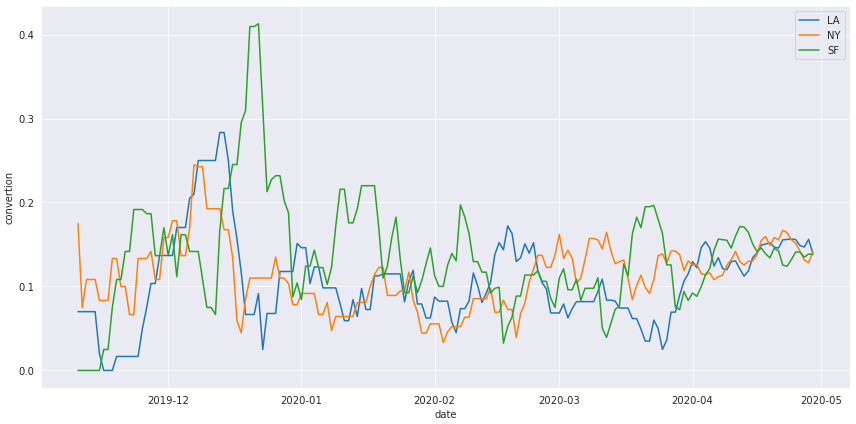

In [31]:
convertion_metric_dinamic.plot(
    ef, 
    period='D',
    hue_cols=['city'],
    formula_kwargs=formula_kwargs,
    engine='seaborn',
    smooth=10,
)

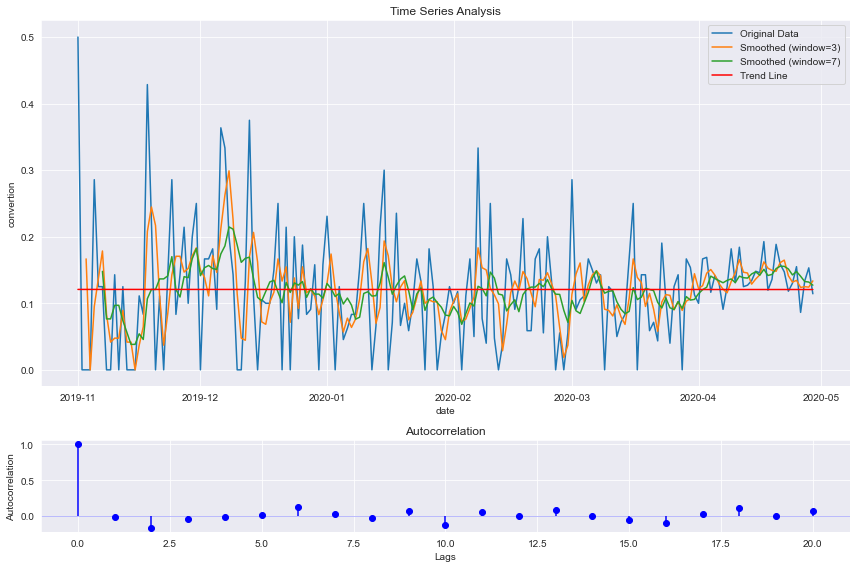

In [33]:
convertion_metric_dinamic.plot_analyze(
    ef, 
    period='D',
    formula_kwargs=formula_kwargs,
    trend_line=True,
    window_sizes=(3, 7),
    lags=20
)

## Поведение пользователей


In [71]:
from ux_researching import Sequences, StepMatrix, StepSankey

In [57]:
step_matrix = StepMatrix(ef)

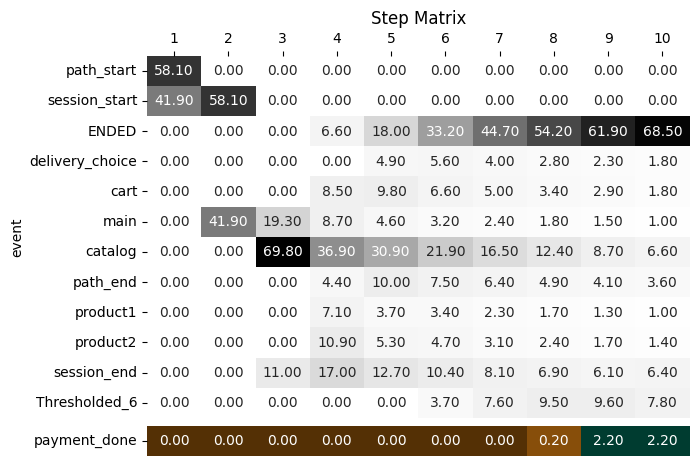

In [58]:
step_matrix.plot(max_steps=10, threshold=0.05, target_events=['payment_done'])

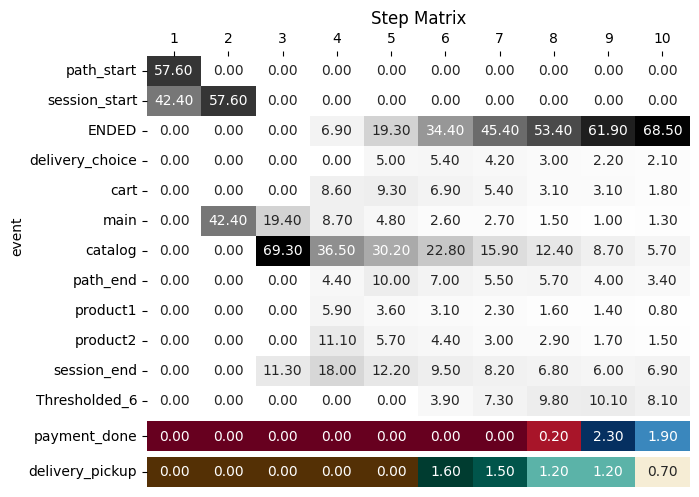

In [64]:
step_matrix.plot(data=ef.filter(conditions=['city == "NY"']),
                 max_steps=10, threshold=0.05, target_events=['payment_done', 'delivery_pickup'])

In [66]:
sequences = Sequences(ef)

In [67]:
sequences.select_freq_sets(ngram_range=(3, 4), support_threshold=0.0, inside_session=False)

,sequence,count,user_id_unique,support,user_id_share
2,cart -> cart -> delivery_choice,1,1,0.000012,0.000267
3,cart -> cart -> delivery_choice -> delivery_co...,1,1,0.000012,0.000267
5,cart -> catalog -> cart,76,72,0.000877,0.019195
6,cart -> catalog -> cart -> catalog,24,24,0.000277,0.006398
7,cart -> catalog -> cart -> delivery_choice,35,35,0.000404,0.009331
...,...,...,...,...,...
521,session_start -> main -> main -> main,33,32,0.000381,0.008531
522,session_start -> main -> main -> session_end,31,30,0.000358,0.007998
523,session_start -> main -> session_end,877,497,0.010122,0.132498
524,session_start -> main -> session_end -> path_end,391,391,0.004513,0.104239


In [70]:
sequences.associative_rules(target_events=['payment_done', 'delivery_pickup'])

,rule,count,support,confidence,lift,user_id_unique,user_id_share
0,catalog -> cart -> delivery_choice => delivery...,293,0.003382,0.293000,50.168433,285,0.075980
1,delivery_choice -> delivery_courier -> payment...,67,0.000773,0.089096,10.933663,66,0.017595
2,delivery_choice -> delivery_pickup -> payment_...,28,0.000323,0.078873,9.679176,28,0.007465
3,delivery_courier -> payment_choice -> payment_...,335,0.003867,0.895722,109.921320,319,0.085044
4,delivery_courier -> payment_choice -> payment_...,74,0.000854,0.544118,66.773100,73,0.019461
5,delivery_pickup -> payment_choice -> payment_c...,172,0.001985,0.900524,110.510568,168,0.044788
6,delivery_pickup -> payment_choice -> payment_c...,30,0.000346,0.491803,60.353179,30,0.007998
7,product1 -> cart -> delivery_choice => deliver...,79,0.000912,0.288321,49.367308,78,0.020794
8,product2 -> cart -> delivery_choice => deliver...,134,0.001547,0.326034,55.824635,132,0.035191


In [72]:
step_sankey = StepSankey(ef)

In [76]:
step_sankey.plot(max_steps=7, threshold=0.05, events_to_keep=['payment_done'], weight_col='user_id', title='Users flow')

data is None
